In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchvision import models
import torch.optim as optim

# Define the transformations: resize, random horizontal flip, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_path = './Dataset1/ColorectalCancer'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a custom ResNet-18 model
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet18, self).__init__()
        resnet = models.resnet18(pretrained=False)  
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Exclude the final classification layer
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

model = CustomResNet18(num_classes=3).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training settings
num_epochs = 10
train_losses, train_accuracies=[],[]
test_losses, test_accuracies=[],[]

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= train_total
   
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # test
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_loss /= test_total

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
    
torch.save(model.features.state_dict(), 'final_feature_resnet18.pth')
print("Final feature model saved.")

Using device: cuda


C:\Users\ClementXu\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ClementXu\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.6857, Train Acc: 72.69%, Test Loss: 0.8352, Test Acc: 62.78%
Epoch [2/10], Train Loss: 0.3719, Train Acc: 85.56%, Test Loss: 1.2287, Test Acc: 63.86%
Epoch [3/10], Train Loss: 0.3089, Train Acc: 88.00%, Test Loss: 0.2580, Test Acc: 89.84%
Epoch [4/10], Train Loss: 0.2477, Train Acc: 90.75%, Test Loss: 0.9584, Test Acc: 69.78%
Epoch [5/10], Train Loss: 0.1943, Train Acc: 92.60%, Test Loss: 0.9713, Test Acc: 73.77%
Epoch [6/10], Train Loss: 0.1881, Train Acc: 92.96%, Test Loss: 0.3227, Test Acc: 87.59%
Epoch [7/10], Train Loss: 0.1619, Train Acc: 94.12%, Test Loss: 0.1063, Test Acc: 95.84%
Epoch [8/10], Train Loss: 0.1453, Train Acc: 94.83%, Test Loss: 0.4513, Test Acc: 87.09%
Epoch [9/10], Train Loss: 0.1061, Train Acc: 96.06%, Test Loss: 0.4220, Test Acc: 83.26%
Epoch [10/10], Train Loss: 0.1176, Train Acc: 95.96%, Test Loss: 0.1757, Test Acc: 93.67%
Final feature model saved.


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues", xticks_rotation="horizontal")
    plt.title(title)
    plt.show()

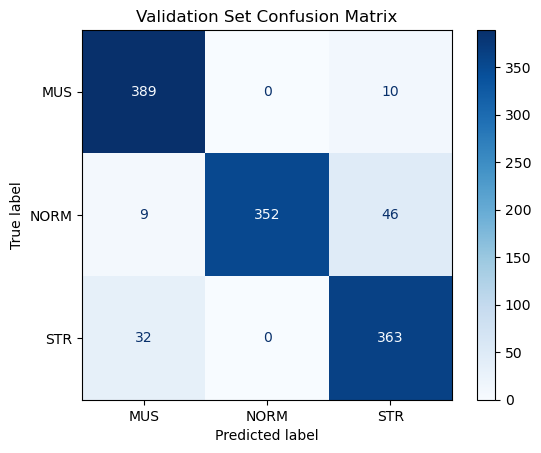

In [31]:
# Validation with Confusion Matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_loss /= test_total

# Generate Confusion Matrix
plot_confusion_matrix(
    y_true=all_labels, 
    y_pred=all_predictions, 
    classes=dataset.classes, 
    title="Validation Set Confusion Matrix"
)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predictions, target_names=dataset.classes))

              precision    recall  f1-score   support

         MUS       0.90      0.97      0.94       399
        NORM       1.00      0.86      0.93       407
         STR       0.87      0.92      0.89       395

    accuracy                           0.92      1201
   macro avg       0.92      0.92      0.92      1201
weighted avg       0.92      0.92      0.92      1201

